In [57]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return (1.0 / (1.0 + np.exp(-x)))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  (a * (1 - a ))
    
    def __softmax(self, x):
        #return np.exp(x)/(np.sum(np.exp(x),axis=1)[:,None])
        return (np.exp(x)/(np.sum(np.exp(x))))
    
    def __softmax_deriv(self, a):
        #a = softmax(x)
        return a * (1 - a)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__logistic_deriv
            
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    def backward(self, delta, output_layer=False):         
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

class MLP:
    """
    """      
    def __init__(self, layers, activation=[None,'tanh','tanh']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        
        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # calculate the delta of the output layer
        delta=-error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta
    
    def criterion_CELoss(self,y,y_hat):
        error = y*np.log(y_hat)
        loss = -np.sum(error)
        delta = (y_hat-y)
        return loss,delta
        
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)
            
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    def fit(self,X,y,learning_rate=0.1, epochs=10):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i])
                
                # backward pass
                #loss[it],delta=self.criterion_MSE(y[i],y_hat)
                loss[it],delta=self.criterion_CELoss(y[i],y_hat)
                self.backward(delta)

                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    def predict(self, x):
        x = np.array(x)
        output = np.zeros(x.shape[0])
        for i in np.arange(x.shape[0]):
            output[i] = self.forward(x[i,:])
        return output

In [152]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [153]:
import h5py
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
scaler = StandardScaler()
    
label_dummies = pd.get_dummies(label)
X_train, X_test, y_train, y_test = train_test_split(data, label_dummies, shuffle=True)

In [160]:
X_train

array([[ 2195.04241623,   398.14586926,   363.91022875, ...,
           39.56954815,    19.25138631,    16.91879977],
       [-1551.87093016,   -87.80748714,   402.22130862, ...,
           79.35143882,    -2.72996354,    -6.76743821],
       [ -542.96721576, -1375.71316574,   -18.4218857 , ...,
          -47.40210283,    38.2320573 ,   -29.35142621],
       ...,
       [ 1635.79222587,   681.20985316,   589.51486354, ...,
           18.83522707,    19.16970591,   -25.73633061],
       [ 1590.72316023,  -551.68233738,  -388.50372564, ...,
           27.76768519,    16.454084  ,   -33.0400654 ],
       [ -917.21844928, -1174.0645488 ,    70.41552206, ...,
           39.44214866,   -30.64492888,   -14.33352917]])

In [161]:
X_test

array([[ 1861.50096922,   889.04200424,   643.99753141, ...,
          -16.77938131,   -15.50296662,   -16.4134907 ],
       [ 2038.84429684,  1125.2076669 ,   692.75829927, ...,
           -6.65329048,    27.54446304,    16.27463258],
       [-1634.28678339,   -12.29377958,   380.35867455, ...,
          -45.57989119,   -51.30817423,    16.86802562],
       ...,
       [ 1252.02687356,  1168.80858804,  -880.57452176, ...,
          -37.81638965,   -36.64731278,  -115.16321564],
       [  183.90118644, -1179.26083234,  -917.8536773 , ...,
           38.30567703,    14.75327532,    26.1759778 ],
       [ 1603.03632723, -1251.62211237,  -760.6363037 , ...,
           65.60571282,   -21.60767317,   -31.68153112]])

In [ ]:
from sklearn.model_selection import KFold

In [179]:
import h5py
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
scaler = StandardScaler()
    
label_dummies = pd.get_dummies(label)
X_train, X_test, y_train, y_test = train_test_split(data, label_dummies, shuffle=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
accuracies_train = []
accuracies_test = []
for lr in [0.001,0.005,0.01,0.02,0.05,0.1,0.2]:
    mlp = MLP([128,32,10],[None,'logistic','softmax'])
    mlp.fit(X_train,y_train, learning_rate=lr, epochs=5)
    yhat_train = mlp.forward(X_train)
    yhat_test = mlp.forward(X_test)
    accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
    accuracy_test = (np.sum(np.argmax(np.array(y_test),axis=1)==np.argmax(yhat_test,axis=1)))/(y_test.shape[0])
    accuracies_train.append(accuracy_train)
    accuracies_test.append(accuracy_test)

In [172]:
accuracies_train

[0.8028666666666666,
 0.8602444444444445,
 0.8771333333333333,
 0.8758444444444444,
 0.8751555555555556]

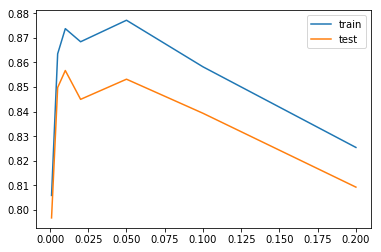

In [182]:
plt.plot([0.001,0.005,0.01,0.02,0.05,0.1,0.2],accuracies_train,label='train')
plt.plot([0.001,0.005,0.01,0.02,0.05,0.1,0.2],accuracies_test,label='test')
plt.legend()